# Laboratory 5: Convolutional Neural Networks

In this laboratory session we will train some CNNs to recognize color images in the [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1: Initial Setup and Data Exploration

We begin with some standard imports, as usual.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Standard Pytorch imports (note the aliases).
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
torch.cuda.is_available()

False

### Exercise 1.1: Dataset and Dataloader Preparation

The `torchvision` library provides a class (with the same interface as MNIST) for the CIFAR-10 dataset. As with MNIST, it will automatically download and prepare the dataset for use. Use the CIFAR10 class to load the training, validation (use 2000 images), and test splits.

**Note**: Don't forget to *transform* the images in the datasets to convert them to tensors and standardize them!

**Hint**: Feel free to copy-and-paste liberally from the notebook I published for the capsule lecture. **BUT**, make sure you know what you are doing, and be aware that *some* of the code will have to be adapted for use with the CIFAR10 dataset.

In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

# Validation set size.
val_size = 2000

#Build a transformation pipeline
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])])

ds_train = CIFAR10('./data', train = True,  download= True, transform = transform)
ds_test = CIFAR10('./data', train = False,  download= True, transform = transform)

100%|██████████| 170498071/170498071 [00:49<00:00, 3460493.79it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print(f'Dataset element:\n{ds_train[0]}')
print(f'ds_train.data dtype: {ds_train.data.dtype}')

Dataset element:
(tensor([[[-1.0527e+00, -1.3068e+00, -1.1956e+00,  ...,  5.1906e-01,
           4.2380e-01,  3.6029e-01],
         [-1.7354e+00, -1.9895e+00, -1.7037e+00,  ..., -3.6628e-02,
          -1.0013e-01, -5.2505e-02],
         [-1.5926e+00, -1.7354e+00, -1.2115e+00,  ..., -1.1601e-01,
          -8.4258e-02, -2.5890e-01],
         ...,
         [ 1.3129e+00,  1.2018e+00,  1.1541e+00,  ...,  5.5081e-01,
          -1.1004e+00, -1.1480e+00],
         [ 8.6835e-01,  7.5721e-01,  9.6361e-01,  ...,  9.3186e-01,
          -4.4942e-01, -6.7170e-01],
         [ 8.2072e-01,  6.7783e-01,  8.5247e-01,  ...,  1.4399e+00,
           4.0792e-01, -3.6628e-02]],

        [[-9.8178e-01, -1.2395e+00, -1.2072e+00,  ...,  1.4557e-01,
           3.2838e-02,  1.6733e-02],
         [-1.6582e+00, -1.9803e+00, -1.8514e+00,  ..., -5.6305e-01,
          -6.4357e-01, -5.7915e-01],
         [-1.5938e+00, -1.8676e+00, -1.5455e+00,  ..., -6.2747e-01,
          -6.2747e-01, -8.0462e-01],
         ...,
       

In [4]:
foo = ds_train[0][0]
foo.shape

torch.Size([3, 32, 32])

In [5]:
data = torch.stack([d[0] for d in ds_train])
foo = data.permute(0,2,3,1)
meanpix = foo.flatten(0,2).mean(0)
stdpix = foo.flatten(0,2).std(0)
meanpix, stdpix

(tensor([-1.2237e-06, -1.7075e-04,  1.1820e-04]),
 tensor([1.0001, 0.9999, 1.0000]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


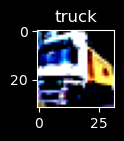

In [6]:
plt.figure(figsize=(1, 1))
plt.title(ds_train.classes[ds_train[1][1]])

# Transpose the dimensions to (32, 32, 3)
image = ds_train[1][0].numpy().transpose((1, 2, 0))

plt.imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


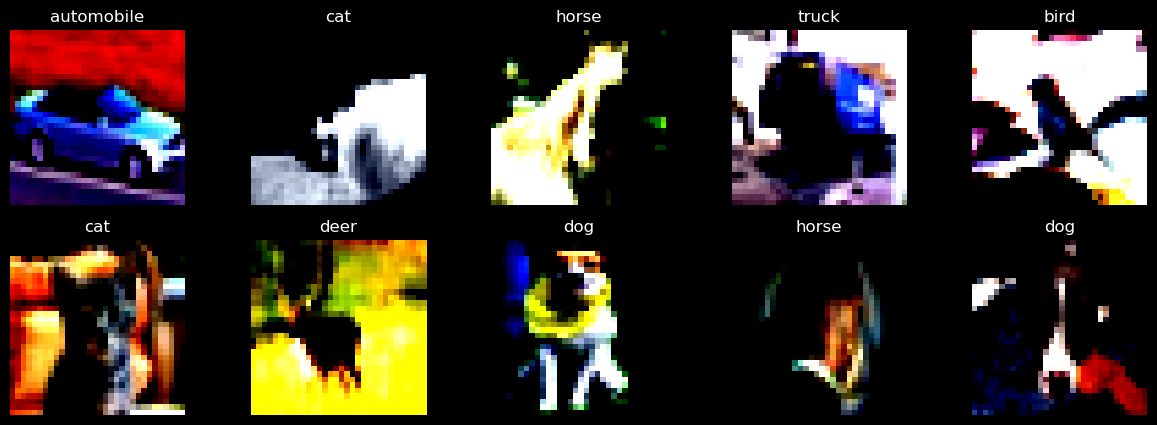

In [7]:
import random
num_images_to_display = 10
random_indices = random.sample(range(len(ds_train)), num_images_to_display)

plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

for i, idx in enumerate(random_indices, 1):
    plt.subplot(2, 5, i)  # 2 rows, 5 columns
    plt.title(ds_train.classes[ds_train[idx][1]])

    # Transpose the dimensions to (32, 32, 3)
    image = ds_train[idx][0].numpy().transpose((1, 2, 0))

    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels
plt.show()

### Exercise 1.2: Dataloaders
Set up dataloaders for **all** of the datasets -- even though the validation set is small! Test out the datasets defined above and the dataloaders to make sure you understand the dataset format. Visualize some of the images to get a feel for the type of images and classes in CIFAR-10.

In [8]:
# Setup dataloaders for all three datasets. Use the largest batch size possible.
from torch.utils.data import Subset, DataLoader
I= np.random.permutation(len(ds_train))
train_size = 45000
val_size = 5000
ds_train_small = Subset(ds_train, I[:train_size])
ds_val = Subset(ds_train, I[train_size: train_size + val_size])


batch_size = 512

dl_train = DataLoader(ds_train_small, batch_size = batch_size, shuffle = True , num_workers=2)
dl_val = DataLoader(ds_val, batch_size = batch_size, num_workers = 2)
dl_test = DataLoader(ds_test, batch_size = batch_size, num_workers = 2)


In [9]:
len(dl_train)

88

## Part 2: Establishing a stable baseline

In this part of the laboratory we will establish a simple baseline as a starting point.

### Exercise 2.1: An MLP Baseline

Define a simple Multilayer Perceptron to classify the CIFAR-10 images. Define it as a class inheriting from torch.nn.Module. Don't make it too complex or too deep. We're just looking for a starting point. A *baseline*.

In [10]:
# Your code here.
# Your code here.
class MLP(torch.nn.Module):
    def __init__(self, inner=128):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, inner)
        self.fc2 = nn.Linear(inner, inner)
        self.out = nn.Linear(inner, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.out(x)
        x = F.log_softmax(x, -1)
        return x

model_mlp = MLP()

In [11]:
#batch = torch.stack([d[0] for d in ds_train_small])[:32]

### Exercise 2.2: Train and Evaluate your MLP Baseline

Train the model for a few (say, 20) epochs. Again, feel free to use my training code from the Capsule Lecture (or roll your own, mine is very basic). Make sure you plot training curves and report accuracy on the test set.

In [12]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())

    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

# Simple function to count the parameters in a model.
def count_parameters(model):
    return np.sum([p.numel() for p in model.parameters()])

In [15]:
# Training hyperparameters.
device = 'mps'
lr = 0.001
epochs = 100

# Instantiate our model and optimizer.
model_mlp = MLP(512).to(device)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=lr)

# Training loop
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, optimizer, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST\n: {evaluate_model(model_mlp, dl_test, device=device)[1]}')

Training epoch 0:   0%|          | 0/88 [00:00<?, ?it/s]

Training epoch 1: 100%|██████████| 88/88 [00:06<00:00, 14.39it/s]


KeyboardInterrupt: 

## Part 3: A CNN for CIFAR-10 Classification

OK, we have a (simple) MLP baseline for comparison. Let's implement a simple CNN to classify CIFAR-10 images and see if we can beat the MLP.

### Exercise 3.1: Defining the CNN

Define a simple CNN model with a few convolutional and maxppooling layers -- not too many, since CIFAR-10 images are only 32x32 pixels! Use two fully-connected layers after the last convolution and before the logit outputs. Test out the model by passing a *single* image through it to make sure it's working.

In [ ]:
# Your code here.
class CNN(nn.Module):
    def __init__(self, channels=32, fc_width=128):
        super().__init__()
        self.conv1_1 = nn.Conv2d(3, channels, 3)
        self.conv1_2 = nn.Conv2d(channels, channels, 3)
        self.conv2_1 = nn.Conv2d(channels, channels, 3)
        self.conv2_2 = nn.Conv2d(channels, channels, 3)
        self.fc1 = nn.Linear(5*5*channels, fc_width)
        self.fc2 = nn.Linear(fc_width, fc_width)
        self.out = nn.Linear(fc_width, 10)

    def forward(self, x):
        x = self.extract(x)
        x = F.log_softmax(self.out(x), -1)
        return x

    def extract(self, x):
        x = F.relu(self.conv1_2(F.relu(self.conv1_1(x))))
        x = F.max_pool2d(x, 2) # 16x16
        x = F.relu(self.conv2_2(F.relu(self.conv2_1(x))))
        x = F.max_pool2d(x, 2) # 8x8
        x = x.view(len(x), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


In [ ]:
batch = torch.stack([d[0] for d in ds_val][:16])
model_cnn = CNN(64)
model_cnn(batch)

tensor([[-2.3038, -2.2394, -2.3606, -2.2369, -2.3334, -2.3564, -2.2842, -2.2458,
         -2.3394, -2.3368],
        [-2.3047, -2.2381, -2.3609, -2.2370, -2.3346, -2.3550, -2.2836, -2.2486,
         -2.3384, -2.3356],
        [-2.3029, -2.2420, -2.3606, -2.2351, -2.3337, -2.3555, -2.2866, -2.2447,
         -2.3398, -2.3356],
        [-2.3082, -2.2388, -2.3605, -2.2348, -2.3324, -2.3569, -2.2844, -2.2456,
         -2.3385, -2.3366],
        [-2.3028, -2.2391, -2.3609, -2.2378, -2.3360, -2.3587, -2.2841, -2.2444,
         -2.3373, -2.3359],
        [-2.3052, -2.2383, -2.3591, -2.2358, -2.3342, -2.3557, -2.2878, -2.2462,
         -2.3386, -2.3356],
        [-2.3050, -2.2379, -2.3609, -2.2353, -2.3349, -2.3530, -2.2866, -2.2488,
         -2.3377, -2.3364],
        [-2.3055, -2.2380, -2.3605, -2.2372, -2.3325, -2.3581, -2.2818, -2.2465,
         -2.3393, -2.3374],
        [-2.3055, -2.2382, -2.3621, -2.2354, -2.3334, -2.3556, -2.2835, -2.2473,
         -2.3387, -2.3373],
        [-2.3047, -

### Exercise 3.2: Training and Evaluating your CNN

Train the CNN using similar hyperparameters to what you used for the MLP above (epochs, learning rate). Evaluate the model in the same way as before.

Training epoch 24: 100%|██████████| 88/88 [00:11<00:00,  7.47it/s]


Accuracy report on TEST
:               precision    recall  f1-score   support

           0      0.740     0.737     0.738      1000
           1      0.780     0.853     0.815      1000
           2      0.635     0.530     0.578      1000
           3      0.528     0.525     0.526      1000
           4      0.689     0.662     0.675      1000
           5      0.528     0.705     0.604      1000
           6      0.814     0.793     0.803      1000
           7      0.829     0.669     0.740      1000
           8      0.805     0.838     0.821      1000
           9      0.808     0.779     0.793      1000

    accuracy                          0.709     10000
   macro avg      0.716     0.709     0.710     10000
weighted avg      0.716     0.709     0.710     10000



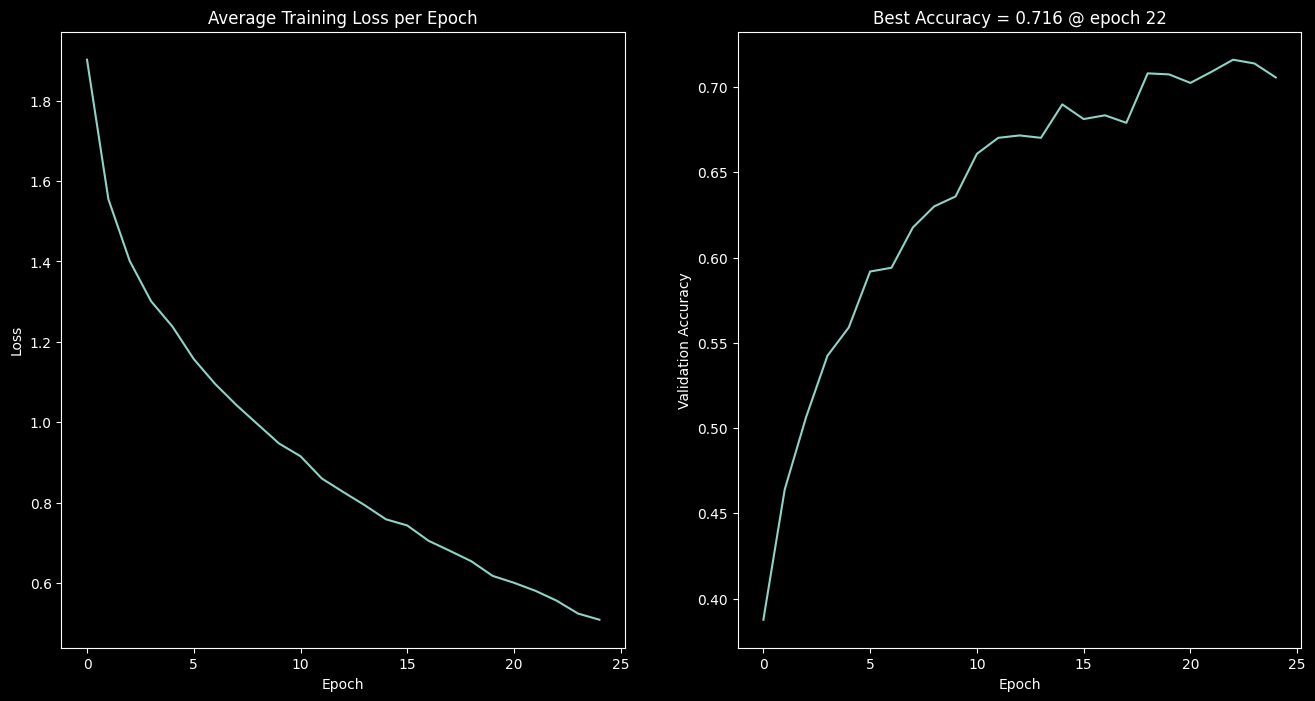

In [ ]:
# Your code here.
# Training hyperparameters.
device = 'cuda'
lr = 0.001
epochs = 25

# Instantiate our model and optimizer.
model_mlp = None
model_cnn = CNN(32).to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=lr)

# Training loop
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_cnn, dl_train, optimizer, epoch, device=device)
    (val_acc, _) = evaluate_model(model_cnn, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST\n: {evaluate_model(model_cnn, dl_test, device=device)[1]}')

## Going Forward

In practice we usually don't train deep models from *scratch*. Especially if we don't have a lot of annotated data we almost always use a **pre-trained** model either as a **feature extractor** or to **fine-tune** on our problem. The Torchvision library supports access to a [huge variety or pre-trained models](https://pytorch.org/vision/stable/models/resnet.html) that you can use for *exactly* this purpose. Keep this in mind if you have an image recognition problem -- you can use a pre-trained model as a **feature extractor** and then train a *simple* MLP to solve your classification problem. This works *very* well in practice.

In [ ]:
X_tr = model_cnn.to('cpu').extract(torch.stack([d[0] for d in ds_train]).to('cpu'))

NameError: ignored

In [ ]:
X_tr = X_tr.detach().numpy()

In [ ]:
labels = np.array([d[1] for d in ds_train])

In [ ]:
from sklearn.svm import LinearSVC
svc = LinearSVC().fit(X_tr, labels)

In [ ]:
X_te = model_cnn.to('cpu').extract(torch.stack([d[0] for d in ds_test]).to('cpu')).detach().numpy()

In [ ]:
test_labels = np.array([d[1] for d in ds_test])

In [ ]:
np.mean(svc.predict(X_te) == test_labels)

In [ ]:
plt.imshow(data[0].permute(1, 2, 0))

In [ ]:
torch.exp(model(data[0:10]))

In [ ]:
data[0:1].shape